In [2]:
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as plt
import ipywidgets as widgets
from IPython.display import display

%matplotlib inline

s_widget = widgets.IntSlider(value=15000, min=0, max=100000, step=1, description='Susceptible:')
s_text = widgets.IntText(value=15000, min=0, max=100000, step=1, description='Susceptible:')
display(s_text)
i_widget = widgets.IntSlider(value=400, min=0, max=100000, step=1, description='Infected:')
i_text = widgets.IntText(value=400, min=0, max=100000, step=1, description='Infected:')
display(i_text)
r_widget = widgets.IntSlider(value=350, min=0, max=100000, step=1, description='Recovered:')
r_text = widgets.IntText(value=350, min=0, max=100000, step=1, description='Recovered:')
display(r_text)
d_widget = widgets.IntSlider(value=100, min=0, max=100000, step=1, description='Dead:')
d_text = widgets.IntText(value=100, min=0, max=100000, step=1, description='Dead:')
display(d_text) 
b_widget = widgets.FloatSlider(value=0.94, min=0, max=3, step=0.01, description='Infection rate:')
b_text = widgets.FloatText(value=0.94, min=0, max=3, step=0.01, description='Infection rate:')
display(b_text)
g_widget = widgets.FloatSlider(value=0.14, min=0, max=1, step=0.01, description='Recovery rate:')
g_text = widgets.FloatText(value=0.14, min=0, max=1, step=0.01, description='Recovery rate:')
display(g_text)
p_widget = widgets.FloatSlider(value=0.05, min=0, max=1, step=0.01, description='Death rate:')
p_text = widgets.FloatText(value=0.05, min=0, max=1, step=0.01, description='Death rate:')
display(p_text)
v_widget = widgets.IntSlider(value=0, min=0, max=100, step=1, description='Vaccination:')
v_text = widgets.IntText(value=0, min=0, max=100, step=1, description='Vaccination:')
display(v_text)

s_link = widgets.jslink((s_text, 'value'), (s_widget, 'value'))
i_link = widgets.jslink((i_text, 'value'), (i_widget, 'value'))
r_link = widgets.jslink((r_text, 'value'), (r_widget, 'value'))
b_link = widgets.jslink((b_text, 'value'), (b_widget, 'value'))
g_link = widgets.jslink((g_text, 'value'), (g_widget, 'value'))
d_link = widgets.jslink((d_text, 'value'), (d_widget, 'value'))
p_link = widgets.jslink((p_text, 'value'), (p_widget, 'value'))
v_link = widgets.jslink((v_text, 'value'), (v_widget, 'value'))

S0 = 15000
I0 = 400
R0 = 350
D0 = 100
V0 = 54
beta = 0.94
gamma = 0.14
phi = 0.05

time_steps = np.linspace(0, 100, 100)

def deriv(y, t, N, beta, gamma):
    S, I, _ = y
    dsdt = -beta * ((S * I) / N) 
    didt = beta * ((S * I) / N) - gamma * I
    drdt = gamma * I
    return dsdt, didt, drdt

def ODESolver(S0, I0, R0, beta, gamma):
    N = S0 + I0 + R0
    y0 = S0, I0, R0
    ret = odeint(deriv, y0, time_steps, args=(N, beta, gamma))
    return ret

def update_plot(S0, I0, R0, beta, gamma):
    S, I, R = ODESolver(S0, I0, R0, beta, gamma).T

    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    ax.plot(time_steps, S/1000, 'b', label='Susceptible')
    ax.plot(time_steps, I/1000, 'r', label='Infected')
    ax.plot(time_steps, R/1000, 'g', label='Recovered with immunity')
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number (1000s)')

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)

    plt.show()
    
widgets.interactive(update_plot, S0=s_widget, I0=i_widget, R0=r_widget, D0=d_widget, beta=b_widget, gamma=g_widget, phi=p_widget, V0=v_widget)

IntText(value=15000, description='Susceptible:')

IntText(value=400, description='Infected:')

IntText(value=350, description='Recovered:')

IntText(value=100, description='Dead:')

FloatText(value=0.94, description='Infection rate:', step=0.01)

FloatText(value=0.14, description='Recovery rate:', step=0.01)

FloatText(value=0.05, description='Death rate:', step=0.01)

IntText(value=0, description='Vaccination:')

interactive(children=(IntSlider(value=15000, description='Susceptible:', max=100000), IntSlider(value=400, des…

{'beta': 0.34408310440218387, 'gamma': 0.17517675009897998}

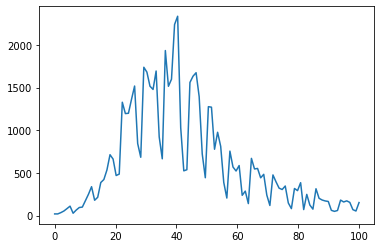

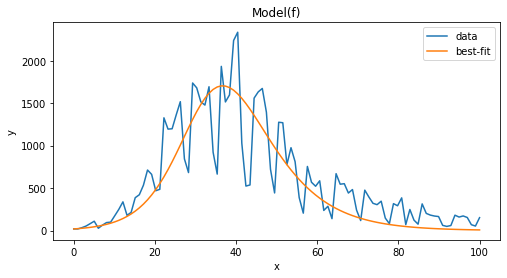

In [9]:
import lmfit 
from lmfit.lineshapes import gaussian, lorentzian
import pandas as pd

np.random.seed(42)
x = np.linspace(0, 100, 100)

data = pd.read_csv("..\Datasets\COVID19BE_CASES_AGESEX.csv")

result = {}

for entry in data.itertuples():
    if entry[1] not in result:
        result[entry[1]] = 0
        result[entry[1]] += entry[6]
    else:
        result[entry[1]] += entry[6]

result_list = list(result.values())
 
plt.plot(x, result_list[0:100])
# Susceptible / 1000, maar Infected is echt getal
def f(x, beta, gamma):
    _, I, _= ODESolver(11500, 19, 0, beta, gamma).T
    return I

mod = lmfit.Model(f)
mod.set_param_hint("beta", value=0.5, vary=True)
mod.set_param_hint("gamma", value=0.5, vary=True)

params = mod.make_params()

result = mod.fit(result_list[0:100], params, method='leastsq', x=x)
plt.figure(figsize=(8, 4))
result.plot_fit(datafmt="-")
# Huidige grafiek geeft nieuwe infecties per dag weer, SIR model geeft geïnfecteerden op een bepaald moment
result.best_values